In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

In [39]:
# Read a file using pandas
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
path = '/content/drive/My Drive/Nat_Cat_Exercise/Events.csv'
df = pd.read_csv(path)

In [41]:
df.head(3)

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry
0,https://www.wpri.com/weather/severe-weather/20...,https://www.wpri.com/weather/severe-weather/20...,2023 was a year of extreme weather in Southern...,20240101T223000Z,https://www.wpri.com/wp-content/uploads/sites/...,wpri.com,English,United States
1,https://volcanoes.usgs.gov/hans2/view/notice/D...,NaN,HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE Mond...,20240101T220000Z,NaN,volcanoes.usgs.gov,English,United States
2,https://www.ktbs.com/online_features/home_impr...,NaN,How to Protect Your Family from Tornadoes,20240101T124500Z,https://bloximages.newyork1.vip.townnews.com/k...,ktbs.com,English,United States


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91479 entries, 0 to 91478
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   url            91479 non-null  object
 1   url_mobile     25383 non-null  object
 2   title          91384 non-null  object
 3   seendate       91479 non-null  object
 4   socialimage    79390 non-null  object
 5   domain         91479 non-null  object
 6   language       91479 non-null  object
 7   sourcecountry  89958 non-null  object
dtypes: object(8)
memory usage: 5.6+ MB


In [43]:
# Dropping the missing from the title column
df = df.dropna(subset=['title'])

In [44]:
# Drop exact duplicate clean titles
df = df.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
print("New shape after deduplication:", df.shape)

New shape after deduplication: (65158, 8)


**Basic EDA**

=== Dataset Overview ===
Number of articles: 65158
Date range: 2024-01-01 00:00:00+00:00 to 2025-01-01 00:15:00+00:00

=== Sample Titles ===
0    2023 was a year of extreme weather in Southern...
1    HAWAIIAN VOLCANO OBSERVATORY DAILY UPDATE Mond...
2            How to Protect Your Family from Tornadoes
3    Iceland volcanoes bring tourists to island cou...
4    Tornados , scorchers and ice storm : Top 10 we...
Name: title, dtype: object

=== Title Length Statistics ===
Average title length: 12.2 words
Shortest title: 1 words
Longest title: 52 words

Title Length - Mean: 70.1803922772338
Missing Titles: 0
Date Range: 2024-01-01 00:00:00+00:00 - 2025-01-01 00:15:00+00:00

=== Missing Values ===
url                  0
url_mobile       45454
title                0
seendate             0
socialimage       8664
domain               0
language             0
sourcecountry     1136
TitleLength          0
title_length         0
word_count           0
dtype: int64


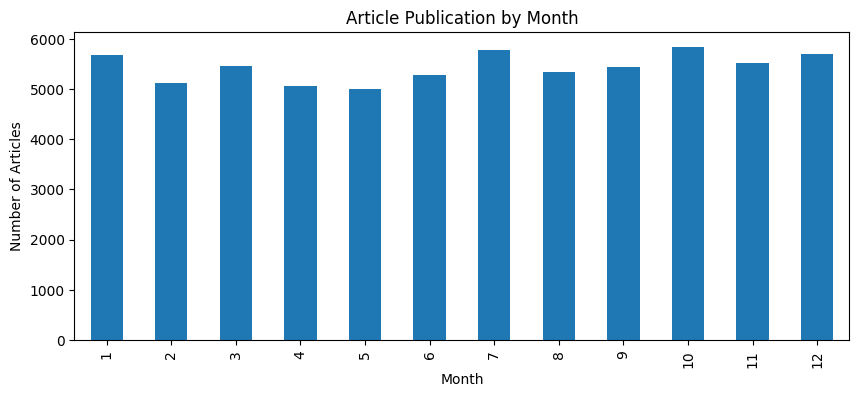

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import nltk
from nltk.tokenize import word_tokenize
#from geotext import GeoText # Removed as it is not used in the code
import spacy

# Load the dataset (assuming it's in CSV format)
df = df.copy()
df['seendate'] = pd.to_datetime(df['seendate'])


# Initial EDA
print("=== Dataset Overview ===")
print(f"Number of articles: {len(df)}")
print(f"Date range: {df['seendate'].min()} to {df['seendate'].max()}")
print("\n=== Sample Titles ===")
print(df['title'].head())

# Calculate title length statistics
df['TitleLength'] = df['title'].astype(str).apply(lambda x: len(x.split()))
print("\n=== Title Length Statistics ===")
print(f"Average title length: {df['TitleLength'].mean():.1f} words")
print(f"Shortest title: {df['TitleLength'].min()} words")
print(f"Longest title: {df['TitleLength'].max()} words")

#  Basic EDA
df['title_length'] = df['title'].astype(str).str.len()
df['word_count'] = df['title'].astype(str).str.split().str.len()

print("\nTitle Length - Mean:", df['title_length'].mean())
print("Missing Titles:", df['title'].isna().sum())
print("Date Range:", df['seendate'].min(), "-", df['seendate'].max())

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

# Plot publication date distribution
plt.figure(figsize=(10, 4))
df['seendate'].dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Article Publication by Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.show()

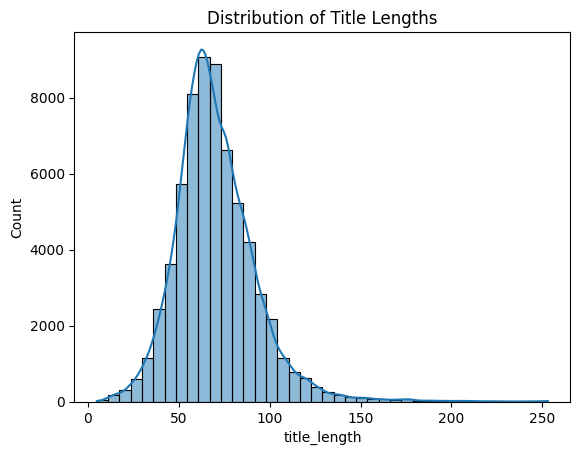

In [46]:
# Plot title lengths
sns.histplot(df['title_length'], bins=40, kde=True)
plt.title("Distribution of Title Lengths")
plt.show()

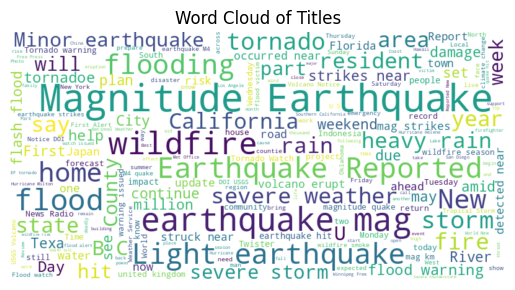

In [47]:
# Word cloud
from wordcloud import WordCloud

text_blob = ' '.join(df['title'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Titles")
plt.show()

**Data Cleaning**

In [48]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [49]:
!pip install geonamescache

In [50]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Ensure NLTK resources are downloaded
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Explicitly download punkt_tab
from nltk.corpus import stopwords

# Load NLP tools
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [51]:
def clean_title(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    doc = nlp(" ".join(filtered_tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens)

df['clean_title'] = df['title'].astype(str).apply(clean_title)


In [52]:
# 4. Clean Titles
#import re
#def clean_title(text):
#    if pd.isna(text):
 #       return ""
  #  text = re.sub(r'[^A-Za-z0-9\s]', '', text)
   # text = re.sub(r'\s+', ' ', text)
    #return text.strip()

#df['clean_title'] = df['title'].astype(str).apply(clean_title)

In [53]:
import spacy
import geonamescache

# Load spaCy model
#nlp = spacy.load("en_core_web_sm")

# Load GeoNames country and city names
gc = geonamescache.GeonamesCache()
countries = set([c['name'] for c in gc.get_countries().values()])
cities = set([c['name'] for c in gc.get_cities().values()])
gazetteer = countries.union(cities)

# Function to check if a title has a real location
def has_location(text):
    doc = nlp(text)

    # Rule 1: spaCy NER match with gazetteer
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC", "FAC"]:
            if ent.text.strip().title() in gazetteer:
                return True

    # Rule 2: Token-level backup match
    tokens = [t.text.strip().title() for t in doc if t.is_alpha]
    if any(tok in gazetteer for tok in tokens):
        return True

    return False


In [54]:
# 6. Detect Nat-Cat Keyword
CATEGORY_KEYWORDS = {
    'Earthquakes': [
        'earthquake', 'tremor', 'seismic', 'quake', 'aftershock', 'foreshock',
        'seism', 'epicenter', 'hypocenter', 'magnitude', 'richter scale',
        'seismic waves', 'ground shaking', 'fault line', 'tectonic', 'liquefaction',
        'seismograph', 'seismology', 'earth movement', 'earth vibration'
    ],

    'Hurricanes': [
        'hurricane', 'typhoon', 'cyclone', 'tropical storm', 'storm surge',
        'eye wall', 'rain bands', 'wind speed', 'category storm', 'tropical depression',
        'gale', 'tempest', 'monsoon', 'low pressure', 'storm system', 'hurricane warning',
        'hurricane watch', 'storm track', 'landfall', 'saffir-simpson'
    ],

    'Tornadoes': [
        'tornado', 'twister', 'funnel cloud', 'whirlwind', 'supercell',
        'mesocyclone', 'vortex', 'windstorm', 'tornado warning', 'tornado watch',
        'tornado siren', 'debris cloud', 'tornado alley', 'rotation', 'wall cloud',
        'hook echo', 'doppler radar', 'fujita scale', 'enhanced fujita', 'tornado outbreak'
    ],

    'Floods': [
        'flood', 'flooding', 'inundation', 'deluge', 'flash flood',
        'torrent', 'high water', 'overflow', 'submersion', 'waterlogging',
        'floodwaters', 'flood damage', 'flood alert', 'flood warning', 'flood watch',
        'levee breach', 'dam break', 'runoff', 'water rise', 'coastal flooding'
    ],

    'Wildfires': [
        'wildfire', 'bushfire', 'forest fire', 'brush fire', 'grass fire',
        'wildland fire', 'firestorm', 'conflagration', 'ember', 'fire spread',
        'fire line', 'fire suppression', 'fire evacuation', 'smoke plume', 'fire season',
        'fire danger', 'red flag warning', 'backfire', 'firebreak', 'containment line'
    ],

    'Tsunamis': [
        'tsunami', 'tidal wave', 'seismic wave', 'harbor wave', 'ocean surge',
        'coastal flooding', 'wave height', 'run-up', 'tsunami warning', 'tsunami alert',
        'tidal bore', 'tsunami advisory', 'seiche', 'displacement wave', 'tsunami siren',
        'tsunami evacuation', 'tsunami zone', 'tsunami buoys', 'megatsunami', 'tsunami ready'
    ],

    'Volcanic eruptions': [
        'volcano', 'eruption', 'lava', 'magma', 'ash cloud',
        'pyroclastic', 'volcanic ash', 'crater', 'caldera', 'fumarole',
        'geyser', 'volcanic gas', 'tephra', 'lahar', 'volcanic bomb',
        'pumice', 'volcanic winter', 'vog', 'volcano alert', 'volcanic explosivity index'
    ]
}
def is_natcat_event(title):
    title = title.lower()
    has_event = any(kw in title for kws in CATEGORY_KEYWORDS.values() for kw in kws)
    return has_event and has_location(title)

df['is_natcat'] = df['clean_title'].apply(is_natcat_event)

In [55]:
# 7. Filter
df_natcat = df[df['is_natcat'] == True].copy()
print("Filtered shape:", df_natcat.shape)

Filtered shape: (18222, 13)


In [56]:
df_natcat.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry,TitleLength,title_length,word_count,clean_title,is_natcat
3,https://www.ctvnews.ca/climate-and-environment...,NaN,Iceland volcanoes bring tourists to island cou...,2024-01-01 22:30:00+00:00,https://www.ctvnews.ca/content/dam/ctvnews/en/...,ctvnews.ca,English,Canada,7,50,7,iceland volcano bring tourist island country,True
4,https://news.yahoo.com/tornados-scorchers-ice-...,NaN,"Tornados , scorchers and ice storm : Top 10 we...",2024-01-01 13:15:00+00:00,https://s.yimg.com/ny/api/res/1.2/PXdWVXp40q9s...,news.yahoo.com,English,United States,17,90,17,tornado scorcher ice storm top 10 weather even...,True
11,https://www.natureworldnews.com/articles/60104...,https://www.natureworldnews.com/amp/articles/6...,Yellowstone Supervolcano Magma Chamber Is Very...,2024-01-01 15:00:00+00:00,https://1471793142.rsc.cdn77.org/data/images/f...,natureworldnews.com,English,United States,14,83,14,yellowstone supervolcano magma chamber huge er...,True
12,https://globalnews.ca/news/10198334/japan-eart...,https://globalnews.ca/news/10198334/japan-eart...,Japan earthquakes : Coastal residents told to ...,2024-01-01 16:15:00+00:00,https://globalnews.ca/wp-content/uploads/2024/...,globalnews.ca,English,Canada,13,87,13,japan earthquake coastal resident tell evacuat...,True
14,https://www.smh.com.au/topic/tsunami-jlj,NaN,Topic | Tsunami | The Sydney Morning Herald,2024-01-01 09:30:00+00:00,https://www.smh.com.au/smh.png,smh.com.au,English,Australia,8,43,8,topic tsunami sydney morning herald,True


In [57]:
# 8. Assign Category
def assign_category(title):
    title = title.lower()
    for category, keywords in CATEGORY_KEYWORDS.items():
        if any(k in title for k in keywords):
            return category
    return "Other"

df_natcat['labels'] = df_natcat['clean_title'].apply(assign_category)

In [58]:
df_natcat.labels.value_counts()

,count
labels,
Earthquakes,5549
Floods,3868
Wildfires,3155
Tornadoes,2735
Hurricanes,1464
Volcanic eruptions,1320
Tsunamis,131


**Approach 1 - > TF-IDF and Logistic Regression**

In [59]:
# 1. Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import spacy

In [60]:
nlp = spacy.load("en_core_web_sm")

In [61]:
df_natcat.reset_index(drop=True, inplace=True)

In [62]:
df_natcat[['clean_title', 'labels']].head()

# 3. Confirm target categories
target_labels = ['Earthquakes', 'Floods', 'Volcanic eruptions', 'Tornadoes', 'Wildfires']
df_natcat = df_natcat[df_natcat['labels'].isin(target_labels)].copy()
print("Filtered shape:", df_natcat.shape)
df_natcat['labels'].value_counts()

Filtered shape: (16627, 14)


,count
labels,
Earthquakes,5549
Floods,3868
Wildfires,3155
Tornadoes,2735
Volcanic eruptions,1320


In [63]:
# 6. TF-IDF Vectorization
X = df_natcat['clean_title']
y = df_natcat['labels']

In [64]:
# 7. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [65]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=500)
X_vect = vectorizer.fit_transform(X_train)

In [66]:
X_vect.shape

(13301, 500)

In [67]:
# 8. Train Classifier
clf = LogisticRegression(max_iter=1000, class_weight='balanced',C=0.5)
clf.fit(X_vect, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000)

In [68]:
# 9. Evaluate Model
y_pred = clf.predict(X_vect)
print("Classification Report:\n", classification_report(y_train, y_pred))

Classification Report:
                     precision    recall  f1-score   support

       Earthquakes       1.00      0.99      0.99      4439
            Floods       0.99      0.99      0.99      3094
         Tornadoes       1.00      0.99      0.99      2188
Volcanic eruptions       0.96      0.99      0.97      1056
         Wildfires       0.98      0.99      0.98      2524

          accuracy                           0.99     13301
         macro avg       0.98      0.99      0.99     13301
      weighted avg       0.99      0.99      0.99     13301



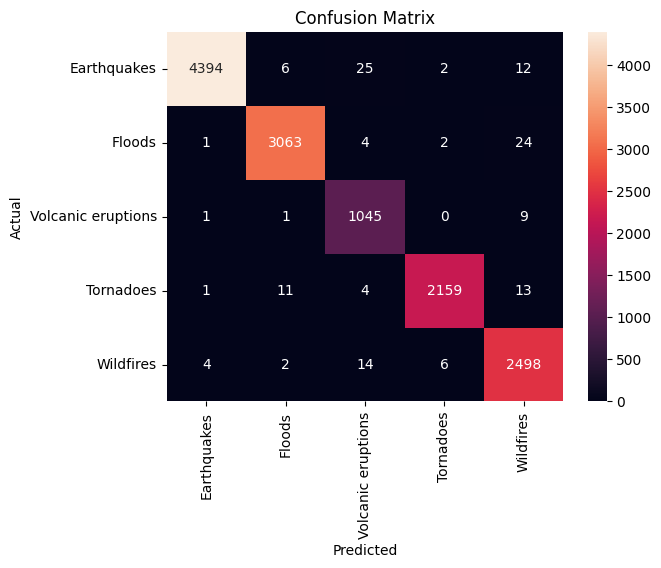

In [69]:
# 10. Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_pred, labels=target_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=target_labels, yticklabels=target_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [70]:
X_test_vect = vectorizer.transform(X_test)

In [71]:
X_test_vect

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20354 stored elements and shape (3326, 500)>

In [72]:
# 9. Evaluate Model
y_pred = clf.predict(X_test_vect)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                     precision    recall  f1-score   support

       Earthquakes       0.99      0.99      0.99      1110
            Floods       0.99      0.98      0.99       774
         Tornadoes       0.99      0.99      0.99       547
Volcanic eruptions       0.96      0.99      0.98       264
         Wildfires       0.97      0.98      0.97       631

          accuracy                           0.98      3326
         macro avg       0.98      0.99      0.98      3326
      weighted avg       0.99      0.98      0.99      3326



In [73]:
# 11. Inference Function
def predict_event_category(title):
    clean = clean_title(title)
    vect = vectorizer.transform([clean])
    return clf.predict(vect)[0]

In [74]:
# 12. Sample Predictions
sample_titles = [
    "Powerful earthquake hits southern Turkey",
    "Massive flooding in Jakarta after monsoon rains",
    "Volcano erupts in Italy spewing ash into the sky",
    "Wildfire spreads near Yosemite National Park",
    "Tornado rips through parts of Oklahoma",
    "Tremors felt across small town",
    "Strong winds reported in Oklahoma",
    "Clouds of ash rising from crater",
    "Heavy rains hit northern region",
    "Fire spreads through forest area",
    "Dry and warm weekend expected",
    "New film breaks box office record"
    "River banks rise after days of monsoon",
    "Explosions heard near base of dormant mountain",
    "High winds twist trees in Missouri",
    "Massive plumes of smoke spotted on satellite",
    "Heavy rains expected across southeast",             # ambiguous, could be flood
    "Disaster warning issued for Pacific region",        # general
    "Major evacuation underway after tremors",           # earthquake, but vague
    "Ash covers sky after sudden mountain explosion"
]

for title in sample_titles:
    predicted = predict_event_category(title)
    print(f"{title} --> {predicted}")

Powerful earthquake hits southern Turkey --> Earthquakes
Massive flooding in Jakarta after monsoon rains --> Floods
Volcano erupts in Italy spewing ash into the sky --> Volcanic eruptions
Wildfire spreads near Yosemite National Park --> Wildfires
Tornado rips through parts of Oklahoma --> Tornadoes
Tremors felt across small town --> Earthquakes
Strong winds reported in Oklahoma --> Wildfires
Clouds of ash rising from crater --> Volcanic eruptions
Heavy rains hit northern region --> Floods
Fire spreads through forest area --> Wildfires
Dry and warm weekend expected --> Wildfires
New film breaks box office recordRiver banks rise after days of monsoon --> Wildfires
Explosions heard near base of dormant mountain --> Wildfires
High winds twist trees in Missouri --> Wildfires
Massive plumes of smoke spotted on satellite --> Wildfires
Heavy rains expected across southeast --> Floods
Disaster warning issued for Pacific region --> Floods
Major evacuation underway after tremors --> Earthquakes
A

**Approach 2 -> SentenceTransformer and RandonForest**

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight sentence encoder
X_embed = model.encode(df_natcat['clean_title'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X_embed, y, stratify=y, test_size=0.3)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

                    precision    recall  f1-score   support

       Earthquakes       0.99      1.00      0.99      1665
            Floods       0.98      0.99      0.98      1160
         Tornadoes       1.00      0.99      0.99       821
Volcanic eruptions       0.97      0.95      0.96       396
         Wildfires       0.98      0.96      0.97       947

          accuracy                           0.98      4989
         macro avg       0.98      0.98      0.98      4989
      weighted avg       0.98      0.98      0.98      4989



**Approach 3 -> Bert + RandomForest**


Classification Report:
                     precision    recall  f1-score   support

       Earthquakes       0.99      0.99      0.99      1665
            Floods       0.98      0.99      0.99      1160
         Tornadoes       1.00      0.99      0.99       821
Volcanic eruptions       0.97      0.95      0.96       396
         Wildfires       0.98      0.96      0.97       947
             Other       0.04      1.00      0.08         1

          accuracy                           0.98      4990
         macro avg       0.83      0.98      0.83      4990
      weighted avg       0.99      0.98      0.99      4990



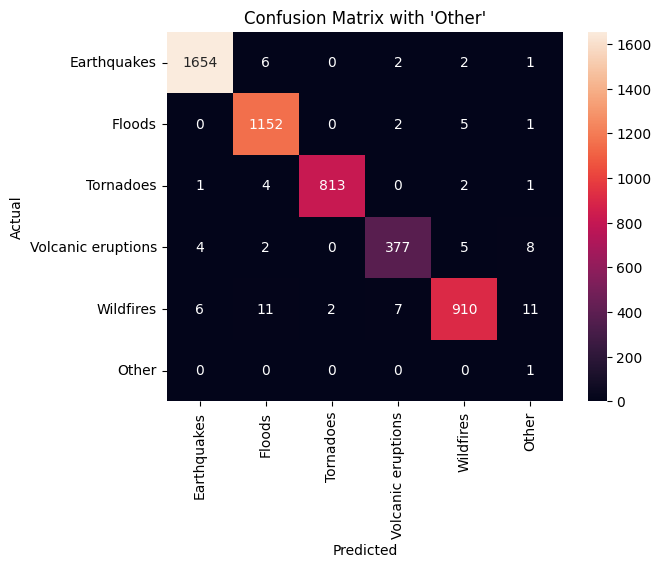


--- Generalization Test ---

Tremors felt across small town --> Earthquakes
Strong winds reported in Oklahoma --> Tornadoes
Clouds of ash rising from crater --> Volcanic eruptions
Heavy rains hit northern region --> Floods
Fire spreads through forest area --> Wildfires
Dry and warm weekend expected --> Wildfires
Taylor Swift performs in Dublin --> Earthquakes
New film breaks box office record --> Other


In [76]:
# NatCat Classifier with BERT + RandomForest + 'Other' Threshold Handling

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import numpy as np


df = df_natcat.copy()
#target_labels = ['Earthquake', 'Floods', 'Volcano', 'Tornado', 'Wildfire']
target_labels = ['Earthquakes', 'Floods', 'Volcanic eruptions', 'Tornadoes', 'Wildfires']


# Optional: mask keywords
def mask_keywords(text):
    for kw in ['Earthquakes', 'Floods', 'Volcanic eruptions', 'Tornadoes', 'Wildfires']:
        text = text.replace(kw, '')
    return text

df['masked_title'] = df['clean_title'].apply(mask_keywords)

# Step 2: BERT Embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(df['masked_title'].tolist(), normalize_embeddings=True)
y = df['labels']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, stratify=y, test_size=0.3, random_state=42)

# Step 4: Train classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Predict with threshold logic
threshold = 0.3
y_probs = rf.predict_proba(X_test)
y_pred = []
for prob in y_probs:
    max_prob = np.max(prob)
    pred_label = rf.classes_[np.argmax(prob)]
    if max_prob < threshold:
        y_pred.append("Other")
    else:
        y_pred.append(pred_label)

# Step 6: Evaluation
all_labels = list(rf.classes_) + ["Other"]

# Extend test labels to include one fake 'Other' to ensure display
y_test_ext = list(y_test) + ["Other"]
y_pred_ext = list(y_pred) + ["Other"]

print("\nClassification Report:\n", classification_report(y_test_ext, y_pred_ext, labels=all_labels))

cm = confusion_matrix(y_test_ext, y_pred_ext, labels=all_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_labels, yticklabels=all_labels)
plt.title("Confusion Matrix with 'Other'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 7: Inference function
def predict_rf(title):
    clean = clean_title(title)
    masked = mask_keywords(clean)
    embed = model.encode([masked], normalize_embeddings=True)
    probs = rf.predict_proba(embed)[0]
    pred = rf.classes_[np.argmax(probs)]
    return pred if max(probs) >= threshold else "Other"

# Step 8: Test on noisy and ambiguous headlines
test_titles = [
    "Tremors felt across small town",
    "Strong winds reported in Oklahoma",
    "Clouds of ash rising from crater",
    "Heavy rains hit northern region",
    "Fire spreads through forest area",
    "Dry and warm weekend expected",
    "Taylor Swift performs in Dublin",
    "New film breaks box office record"
]

print("\n--- Generalization Test ---\n")
for title in test_titles:
    print(f"{title} --> {predict_rf(title)}")


**Zero shot Classification**

In [77]:
from transformers import pipeline
import pandas as pd

df = df_natcat.copy()

# Define labels and threshold
candidate_labels = ["Earthquake", "Floods", "Volcano", "Tornado", "Wildfire"]
threshold = 0.5

# Load zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Run zero-shot classification
results = classifier(df['title'].tolist(), candidate_labels=candidate_labels)

# Extract final labels with threshold logic
final_labels = []
top_scores = []

for result in results:
    labels = result['labels']
    scores = result['scores']
    top_index = scores.index(max(scores))
    top_label = labels[top_index]
    top_score = scores[top_index]
    final_label = top_label if top_score >= threshold else "Others"
    final_labels.append(final_label)
    top_scores.append(top_score)

# Add results to DataFrame
df['final_label'] = final_labels
df['top_score'] = top_scores

# View result
print(df[['title', 'final_label', 'top_score']])


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


                                                   title final_label  \
0      Iceland volcanoes bring tourists to island cou...     Volcano   
1      Tornados , scorchers and ice storm : Top 10 we...     Tornado   
2      Yellowstone Supervolcano Magma Chamber Is Very...     Volcano   
3      Japan earthquakes : Coastal residents told to ...  Earthquake   
5      DSWD DROMIC Report on the Tornado Incident in ...     Tornado   
...                                                  ...         ...   
18216  LIVE : Israel continues to block Gaza aid ; he...      Floods   
18217  Montgomery County leaders try to secure federa...     Tornado   
18218    IT DOESNT SEEM FAIR : Residents deal with to...     Tornado   
18219  In event of an earthquake , insurance industry...  Earthquake   
18220  Montgomery County crime : Authorities detain d...     Tornado   

       top_score  
0       0.970039  
1       0.952317  
2       0.979111  
3       0.926220  
5       0.984711  
...          ...  
18

In [78]:
df.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry,TitleLength,title_length,word_count,clean_title,is_natcat,labels,final_label,top_score
0,https://www.ctvnews.ca/climate-and-environment...,NaN,Iceland volcanoes bring tourists to island cou...,2024-01-01 22:30:00+00:00,https://www.ctvnews.ca/content/dam/ctvnews/en/...,ctvnews.ca,English,Canada,7,50,7,iceland volcano bring tourist island country,True,Volcanic eruptions,Volcano,0.970039
1,https://news.yahoo.com/tornados-scorchers-ice-...,NaN,"Tornados , scorchers and ice storm : Top 10 we...",2024-01-01 13:15:00+00:00,https://s.yimg.com/ny/api/res/1.2/PXdWVXp40q9s...,news.yahoo.com,English,United States,17,90,17,tornado scorcher ice storm top 10 weather even...,True,Tornadoes,Tornado,0.952317
2,https://www.natureworldnews.com/articles/60104...,https://www.natureworldnews.com/amp/articles/6...,Yellowstone Supervolcano Magma Chamber Is Very...,2024-01-01 15:00:00+00:00,https://1471793142.rsc.cdn77.org/data/images/f...,natureworldnews.com,English,United States,14,83,14,yellowstone supervolcano magma chamber huge er...,True,Volcanic eruptions,Volcano,0.979111
3,https://globalnews.ca/news/10198334/japan-eart...,https://globalnews.ca/news/10198334/japan-eart...,Japan earthquakes : Coastal residents told to ...,2024-01-01 16:15:00+00:00,https://globalnews.ca/wp-content/uploads/2024/...,globalnews.ca,English,Canada,13,87,13,japan earthquake coastal resident tell evacuat...,True,Earthquakes,Earthquake,0.926220
5,https://reliefweb.int/report/philippines/dswd-...,NaN,DSWD DROMIC Report on the Tornado Incident in ...,2024-01-01 09:30:00+00:00,https://reliefweb.int/sites/default/files/styl...,reliefweb.int,English,Syria,23,113,23,dswd dromic report tornado incident brgy rizal...,True,Tornadoes,Tornado,0.984711


In [79]:
df.final_label.value_counts()

,count
final_label,
Earthquake,5438
Floods,3881
Wildfire,3027
Tornado,2669
Volcano,1401
Others,211


In [80]:
df.labels.value_counts()

,count
labels,
Earthquakes,5549
Floods,3868
Wildfires,3155
Tornadoes,2735
Volcanic eruptions,1320


**Zero shot + Logistic regression**

In [81]:
# 6. TF-IDF Vectorization
X = df['clean_title']
y = df['final_label']

In [82]:
# 7. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=1000)
X_vect = vectorizer.fit_transform(X_train)

In [84]:
# 8. Train Classifier
clf = LogisticRegression(max_iter=1000, class_weight='balanced',C=0.5)
clf.fit(X_vect, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000)

In [85]:
# 9. Evaluate Model
y_pred = clf.predict(X_vect)
print("Classification Report:\n", classification_report(y_train, y_pred))

Classification Report:
               precision    recall  f1-score   support

  Earthquake       1.00      0.98      0.99      4350
      Floods       1.00      0.99      0.99      3105
      Others       0.51      0.98      0.67       169
     Tornado       0.99      0.99      0.99      2135
     Volcano       0.99      0.98      0.98      1121
    Wildfire       1.00      0.98      0.99      2421

    accuracy                           0.98     13301
   macro avg       0.91      0.98      0.94     13301
weighted avg       0.99      0.98      0.99     13301



In [86]:
target_labels = ['Earthquake', 'Floods', 'Volcano', 'Tornado', 'Wildfire','Others']

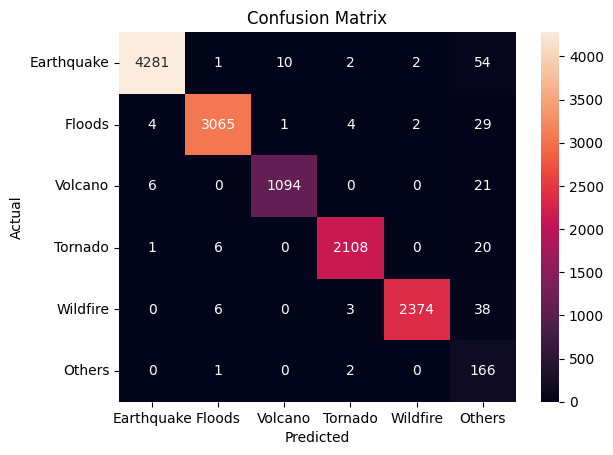

In [87]:
# 10. Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_pred, labels=target_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=target_labels, yticklabels=target_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [88]:
# 11. Inference Function
def predict_event_category(title):
    clean = clean_title(title)
    vect = vectorizer.transform([clean])
    return clf.predict(vect)[0]

In [89]:
# 12. Sample Predictions
sample_titles = [
    "Powerful earthquake hits southern Turkey",
    "Massive flooding in Jakarta after monsoon rains",
    "Volcano erupts in Italy spewing ash into the sky",
    "Wildfire spreads near Yosemite National Park",
    "Tornado rips through parts of Oklahoma",
    "Tremors felt across small town",
    "Strong winds reported in Oklahoma",
    "Clouds of ash rising from crater",
    "Heavy rains hit northern region",
    "Fire spreads through forest area",
    "Dry and warm weekend expected",
    "New film breaks box office record"
    "River banks rise after days of monsoon",
    "Explosions heard near base of dormant mountain",
    "High winds twist trees in Missouri",
    "Massive plumes of smoke spotted on satellite",
    "Heavy rains expected across southeast",             # ambiguous, could be flood
    "Disaster warning issued for Pacific region",        # general
    "Major evacuation underway after tremors",           # earthquake, but vague
    "Ash covers sky after sudden mountain explosion"
]

for title in sample_titles:
    predicted = predict_event_category(title)
    print(f"{title} --> {predicted}")

Powerful earthquake hits southern Turkey --> Earthquake
Massive flooding in Jakarta after monsoon rains --> Floods
Volcano erupts in Italy spewing ash into the sky --> Volcano
Wildfire spreads near Yosemite National Park --> Wildfire
Tornado rips through parts of Oklahoma --> Tornado
Tremors felt across small town --> Others
Strong winds reported in Oklahoma --> Others
Clouds of ash rising from crater --> Volcano
Heavy rains hit northern region --> Floods
Fire spreads through forest area --> Wildfire
Dry and warm weekend expected --> Others
New film breaks box office recordRiver banks rise after days of monsoon --> Others
Explosions heard near base of dormant mountain --> Others
High winds twist trees in Missouri --> Others
Massive plumes of smoke spotted on satellite --> Others
Heavy rains expected across southeast --> Floods
Disaster warning issued for Pacific region --> Others
Major evacuation underway after tremors --> Wildfire
Ash covers sky after sudden mountain explosion --> Oth

**Zero shot + Random Forest**


Classification Report:
               precision    recall  f1-score   support

  Earthquake       0.98      1.00      0.99      1632
      Floods       0.98      0.98      0.98      1165
      Others       1.00      0.02      0.03        63
     Tornado       0.98      0.99      0.99       801
     Volcano       0.98      0.95      0.96       420
    Wildfire       0.98      0.99      0.99       908

   micro avg       0.98      0.98      0.98      4989
   macro avg       0.98      0.82      0.82      4989
weighted avg       0.98      0.98      0.97      4989



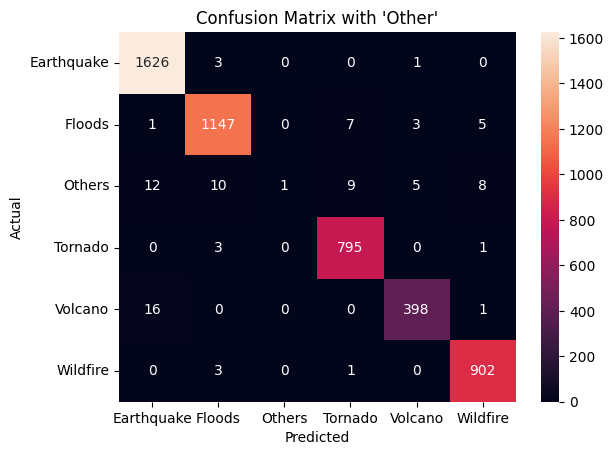


--- Generalization Test ---

Tremors felt across small town --> Earthquake
Strong winds reported in Oklahoma --> Tornado
Clouds of ash rising from crater --> Volcano
Heavy rains hit northern region --> Floods
Fire spreads through forest area --> Wildfire
Dry and warm weekend expected --> Floods
Taylor Swift performs in Dublin --> Earthquake
New film breaks box office record --> Others


In [90]:
# NatCat Classifier with BERT + RandomForest + 'Other' Threshold Handling

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import numpy as np


df = df.copy()
target_labels = ['Earthquake', 'Floods', 'Volcano', 'Tornado', 'Wildfire']
#target_labels = ['Earthquakes', 'Floods', 'Volcanic eruptions', 'Tornadoes', 'Wildfires']


# Optional: mask keywords
def mask_keywords(text):
    for kw in ['Earthquakes', 'Floods', 'Volcanic eruptions', 'Tornadoes', 'Wildfires']:
        text = text.replace(kw, '')
    return text

df['masked_title'] = df['clean_title'].apply(mask_keywords)

# Step 2: BERT Embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(df['masked_title'].tolist(), normalize_embeddings=True)
y = df['final_label']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, stratify=y, test_size=0.3, random_state=42)

# Step 4: Train classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Predict with threshold logic
threshold = 0.3
y_probs = rf.predict_proba(X_test)
y_pred = []
for prob in y_probs:
    max_prob = np.max(prob)
    pred_label = rf.classes_[np.argmax(prob)]
    if max_prob < threshold:
        y_pred.append("Other")
    else:
        y_pred.append(pred_label)

# Step 6: Evaluation
all_labels = list(rf.classes_)

# Extend test labels to include one fake 'Other' to ensure display
y_test_ext = list(y_test)
y_pred_ext = list(y_pred)

print("\nClassification Report:\n", classification_report(y_test_ext, y_pred_ext, labels=all_labels))

cm = confusion_matrix(y_test_ext, y_pred_ext, labels=all_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_labels, yticklabels=all_labels)
plt.title("Confusion Matrix with 'Other'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 7: Inference function
def predict_rf(title):
    clean = clean_title(title)
    masked = mask_keywords(clean)
    embed = model.encode([masked], normalize_embeddings=True)
    probs = rf.predict_proba(embed)[0]
    pred = rf.classes_[np.argmax(probs)]
    return pred if max(probs) >= threshold else "Others"

# Step 8: Test on noisy and ambiguous headlines
test_titles = [
    "Tremors felt across small town",
    "Strong winds reported in Oklahoma",
    "Clouds of ash rising from crater",
    "Heavy rains hit northern region",
    "Fire spreads through forest area",
    "Dry and warm weekend expected",
    "Taylor Swift performs in Dublin",
    "New film breaks box office record"
]

print("\n--- Generalization Test ---\n")
for title in test_titles:
    print(f"{title} --> {predict_rf(title)}")

In [91]:
# 12. Sample Predictions
sample_titles = [
    "Powerful earthquake hits southern Turkey",
    "Massive flooding in Jakarta after monsoon rains",
    "Volcano erupts in Italy spewing ash into the sky",
    "Wildfire spreads near Yosemite National Park",
    "Tornado rips through parts of Oklahoma",
    "Tremors felt across small town",
    "Strong winds reported in Oklahoma",
    "Clouds of ash rising from crater",
    "Heavy rains hit northern region",
    "Fire spreads through forest area",
    "Dry and warm weekend expected",
    "New film breaks box office record"
    "River banks rise after days of monsoon",
    "Explosions heard near base of dormant mountain",
    "High winds twist trees in Missouri",
    "Massive plumes of smoke spotted on satellite",
    "Heavy rains expected across southeast",             # ambiguous, could be flood
    "Disaster warning issued for Pacific region",        # general
    "Major evacuation underway after tremors",           # earthquake, but vague
    "Ash covers sky after sudden mountain explosion"
]

for title in sample_titles:
    predicted = predict_rf(title)
    print(f"{title} --> {predicted}")

Powerful earthquake hits southern Turkey --> Earthquake
Massive flooding in Jakarta after monsoon rains --> Floods
Volcano erupts in Italy spewing ash into the sky --> Volcano
Wildfire spreads near Yosemite National Park --> Wildfire
Tornado rips through parts of Oklahoma --> Tornado
Tremors felt across small town --> Earthquake
Strong winds reported in Oklahoma --> Tornado
Clouds of ash rising from crater --> Volcano
Heavy rains hit northern region --> Floods
Fire spreads through forest area --> Wildfire
Dry and warm weekend expected --> Floods
New film breaks box office recordRiver banks rise after days of monsoon --> Floods
Explosions heard near base of dormant mountain --> Earthquake
High winds twist trees in Missouri --> Tornado
Massive plumes of smoke spotted on satellite --> Wildfire
Heavy rains expected across southeast --> Floods
Disaster warning issued for Pacific region --> Earthquake
Major evacuation underway after tremors --> Earthquake
Ash covers sky after sudden mountain


Classification Report:
               precision    recall  f1-score   support

  Earthquake       1.00      0.98      0.99      1632
      Floods       0.99      0.98      0.98      1165
      Others       0.50      0.78      0.61        63
     Tornado       0.98      0.99      0.99       801
     Volcano       0.97      0.98      0.97       420
    Wildfire       0.99      0.99      0.99       908

   micro avg       0.98      0.98      0.98      4989
   macro avg       0.91      0.95      0.92      4989
weighted avg       0.98      0.98      0.98      4989



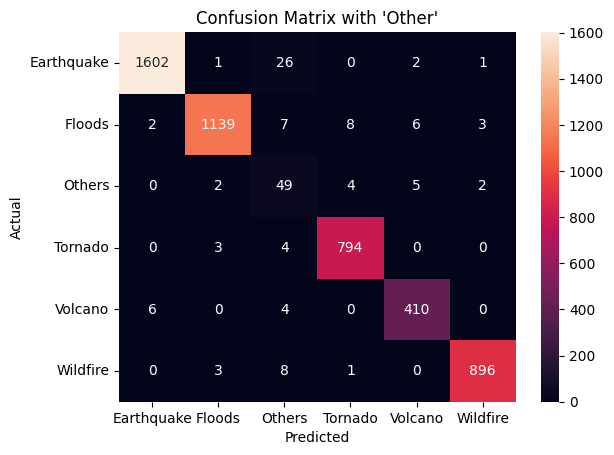


--- Generalization Test ---

Tremors felt across small town --> Earthquake
Strong winds reported in Oklahoma --> Others
Clouds of ash rising from crater --> Volcano
Heavy rains hit northern region --> Floods
Fire spreads through forest area --> Wildfire
Dry and warm weekend expected --> Others
Taylor Swift performs in Dublin --> Others
New film breaks box office record --> Others


In [92]:
# NatCat Classifier with BERT + Logistic Regressio + 'Other' Threshold Handling

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import numpy as np


df = df.copy()
target_labels = ['Earthquake', 'Floods', 'Volcano', 'Tornado', 'Wildfire']
#target_labels = ['Earthquakes', 'Floods', 'Volcanic eruptions', 'Tornadoes', 'Wildfires']


# Optional: mask keywords
def mask_keywords(text):
    for kw in ['Earthquakes', 'Floods', 'Volcanic eruptions', 'Tornadoes', 'Wildfires']:
        text = text.replace(kw, '')
    return text

df['masked_title'] = df['clean_title'].apply(mask_keywords)

# Step 2: BERT Embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(df['masked_title'].tolist(), normalize_embeddings=True)
y = df['final_label']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, stratify=y, test_size=0.3, random_state=42)

# 8. Train Classifier
clf1 = LogisticRegression(max_iter=1000, class_weight='balanced',C=0.5)
clf1.fit(X_train, y_train)


# Step 5: Predict with threshold logic
threshold = 0.3
y_probs = clf1.predict_proba(X_test)
y_pred = []
for prob in y_probs:
    max_prob = np.max(prob)
    pred_label = clf1.classes_[np.argmax(prob)]
    if max_prob < threshold:
        y_pred.append("Other")
    else:
        y_pred.append(pred_label)

# Step 6: Evaluation
all_labels = list(clf1.classes_)

# Extend test labels to include one fake 'Other' to ensure display
y_test_ext = list(y_test)
y_pred_ext = list(y_pred)

print("\nClassification Report:\n", classification_report(y_test_ext, y_pred_ext, labels=all_labels))

cm = confusion_matrix(y_test_ext, y_pred_ext, labels=all_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_labels, yticklabels=all_labels)
plt.title("Confusion Matrix with 'Other'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 7: Inference function
def predict_with_logistic_regression(title):
    clean = clean_title(title)
    masked = mask_keywords(clean)
    embed = model.encode([masked], normalize_embeddings=True)
    probs = clf1.predict_proba(embed)[0]
    pred = clf1.classes_[np.argmax(probs)]
    return pred if max(probs) >= threshold else "Others"

# Step 8: Test on noisy and ambiguous headlines
test_titles = [
    "Tremors felt across small town",
    "Strong winds reported in Oklahoma",
    "Clouds of ash rising from crater",
    "Heavy rains hit northern region",
    "Fire spreads through forest area",
    "Dry and warm weekend expected",
    "Taylor Swift performs in Dublin",
    "New film breaks box office record"
]

print("\n--- Generalization Test ---\n")
for title in test_titles:
    print(f"{title} --> {predict_with_logistic_regression(title)}")

In [93]:
# 12. Sample Predictions
sample_titles = [
    "Powerful earthquake hits southern Turkey",
    "Massive flooding in Jakarta after monsoon rains",
    "Volcano erupts in Italy spewing ash into the sky",
    "Wildfire spreads near Yosemite National Park",
    "Tornado rips through parts of Oklahoma",
    "Tremors felt across small town",
    "Strong winds reported in Oklahoma",
    "Clouds of ash rising from crater",
    "Heavy rains hit northern region",
    "Fire spreads through forest area",
    "Dry and warm weekend expected",
    "New film breaks box office record"
    "River banks rise after days of monsoon",
    "Explosions heard near base of dormant mountain",
    "High winds twist trees in Missouri",
    "Massive plumes of smoke spotted on satellite",
    "Heavy rains expected across southeast",             # ambiguous, could be flood
    "Disaster warning issued for Pacific region",        # general
    "Major evacuation underway after tremors",           # earthquake, but vague
    "Ash covers sky after sudden mountain explosion"
]

for title in sample_titles:
    predicted = predict_with_logistic_regression(title)
    print(f"{title} --> {predicted}")

Powerful earthquake hits southern Turkey --> Earthquake
Massive flooding in Jakarta after monsoon rains --> Floods
Volcano erupts in Italy spewing ash into the sky --> Volcano
Wildfire spreads near Yosemite National Park --> Wildfire
Tornado rips through parts of Oklahoma --> Tornado
Tremors felt across small town --> Earthquake
Strong winds reported in Oklahoma --> Others
Clouds of ash rising from crater --> Volcano
Heavy rains hit northern region --> Floods
Fire spreads through forest area --> Wildfire
Dry and warm weekend expected --> Others
New film breaks box office recordRiver banks rise after days of monsoon --> Others
Explosions heard near base of dormant mountain --> Others
High winds twist trees in Missouri --> Tornado
Massive plumes of smoke spotted on satellite --> Others
Heavy rains expected across southeast --> Floods
Disaster warning issued for Pacific region --> Earthquake
Major evacuation underway after tremors --> Earthquake
Ash covers sky after sudden mountain explos

**Bert Classification**